In [1]:
import pandas as pd
import numpy as np
#for text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')
#nltk.download('wordnet')
#for model-building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
#for word embedding
#import gensim
#from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [2]:
from sklearn.datasets import fetch_20newsgroups
import pandas as pd

def twenty_newsgroup_to_csv():
    newsgroups_train = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))

    df = pd.DataFrame([newsgroups_train.data, newsgroups_train.target.tolist()]).T
    df.columns = ['text', 'target']

    targets = pd.DataFrame( newsgroups_train.target_names)
    targets.columns=['title']

    out = pd.merge(df, targets, left_on='target', right_index=True)
    out['date'] = pd.to_datetime('now')
    out.to_csv('20_newsgroup.csv')

twenty_newsgroup_to_csv()

C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\pandas\core\arrays\datetimes.py:2199: FutureWarning: The parsing of 'now' in pd.to_datetime without `utc=True` is deprecated. In a future version, this will match Timestamp('now') and Timestamp.now()
  result, tz_parsed = tslib.array_to_datetime(


In [3]:
data = pd.read_csv('20_newsgroup.csv', index_col = 0)
# Select only 5 classes
class_mask = data["target"].isin([7,9,13,18,19])
data = data[class_mask]
data.head()

,text,target,title,date
9,\nIf a Christian means someone who believes in...,19,talk.religion.misc,2022-04-05 20:44:46.874893
10,the blood of the lamb.\n\nThis will be a hard ...,19,talk.religion.misc,2022-04-05 20:44:46.874893
12,930418\n\nDo what thou wilt shall be the whole...,19,talk.religion.misc,2022-04-05 20:44:46.874893
40,\n\nNo. Zeno's paradox is resolved by showing...,19,talk.religion.misc,2022-04-05 20:44:46.874893
58,"\nDefinitely, J.R. ""Bob"" Dobbs, numero uno, to...",19,talk.religion.misc,2022-04-05 20:44:46.874893


In [4]:
#SPLITTING THE TRAINING DATASET INTO TRAIN AND TEST
df_train, df_test = train_test_split(data,test_size=0.1,shuffle=True, random_state=1)

In [5]:
! pip install seaborn

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

9     905
13    892
7     886
18    686
19    570
Name: target, dtype: int64


C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='target'>

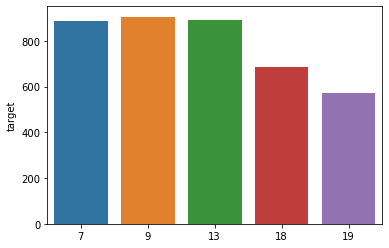

In [7]:
x=df_train['target'].value_counts()
print(x)
sns.barplot(x.index,x)

In [8]:
df_train.isna().sum()

text      108
target      0
title       0
date        0
dtype: int64

In [9]:
# WORD-COUNT
df_train['word_count'] = df_train['text'].apply(lambda x: len(str(x).split()))
print(df_train[df_train['target']==7]['word_count'].mean()) #Disaster tweets
print(df_train[df_train['target']==9]['word_count'].mean()) #Non-Disaster tweets

111.67381489841986
125.91381215469613


In [10]:
df_train = df_train.dropna()
df_test = df_test.dropna()

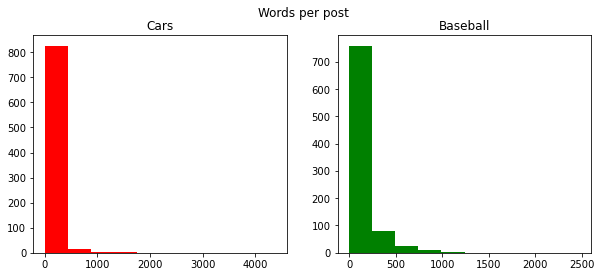

In [11]:
# PLOTTING WORD-COUNT
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))
train_words=df_train[df_train['target']==7]['word_count']
ax1.hist(train_words,color='red')
ax1.set_title('Cars')
train_words=df_train[df_train['target']==9]['word_count']
ax2.hist(train_words,color='green')
ax2.set_title('Baseball')
fig.suptitle('Words per post')
plt.show()

In [12]:
# CHARACTER-COUNT
df_train['char_count'] = df_train['text'].apply(lambda x: len(str(x)))
print(df_train[df_train['target']==7]['char_count'].mean()) # Cars
print(df_train[df_train['target']==9]['char_count'].mean()) # Baseball

675.8110979929162
753.5956719817767


In [13]:
#convert to lowercase, strip and remove punctuations
def preprocess(text):
    text = text.lower()
    text=text.strip()
    text=re.compile('<.*?>').sub('', text)
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)
    text = re.sub('\s+', ' ', text)
    text = re.sub(r'\[[0-9]*\]',' ',text)
    text=re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text)
    text = re.sub(r'\s+',' ',text)
    return text


# STOPWORD REMOVAL
def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)
#LEMMATIZATION
# Initialize the lemmatizer
wl = WordNetLemmatizer()

# This is a helper function to map NTLK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
# Tokenize the sentence
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(a)

In [14]:
def finalpreprocess(string):
    return lemmatizer(stopword(preprocess(string)))
df_train['clean_text'] = df_train['text'].apply(lambda x: finalpreprocess(x))
df_train.head()
df_test['clean_text'] = df_test['text'].apply(lambda x: finalpreprocess(x))

In [15]:
#SPLITTING THE TRAINING DATASET INTO TRAIN AND TEST
X_train, X_val, y_train, y_val = train_test_split(df_train["clean_text"],df_train["title"],test_size=0.2,shuffle=True, stratify=df_train["title"], random_state=2)
X_test = df_test['clean_text']
y_test = df_test['title']
# Word2Vec runs on tokenized sentences
X_train_tok= [nltk.word_tokenize(i) for i in X_train]
X_val_tok= [nltk.word_tokenize(i) for i in X_val]
X_test_tok= [nltk.word_tokenize(i) for i in X_test]

In [16]:
#Tf-Idf vectorizer
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_vectors_tfidf = tfidf_vectorizer.transform(X_val)
X_test_vectors_tfidf = tfidf_vectorizer.transform(X_test)

In [17]:
#FITTING THE CLASSIFICATION MODEL using Logistic Regression(tf-idf)
lr_tfidf=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
lr_tfidf.fit(X_train_vectors_tfidf, y_train)
#Predict y value for test dataset
y_predict = lr_tfidf.predict(X_test_vectors_tfidf)
y_prob = lr_tfidf.predict_proba(X_test_vectors_tfidf)[:,1]
print(classification_report(y_test,y_predict))
print('Confusion Matrix:\n',confusion_matrix(y_test, y_predict))

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, balanced_accuracy_score

lr_acc = accuracy_score(y_test, y_predict)
lr_f1 = f1_score(y_test, y_predict, average ='weighted')
lr_bacc = balanced_accuracy_score(y_test, y_predict)

print(f"Test Accuracy of Logistic Regression(tf-idf) is {lr_acc} \n")
print(f"Test Balanced Accuracy of Logistic Regression(tf-idf) is {lr_bacc} \n")
print(f"Test F1-score weighted of Logistic Regression(tf-idf) is {lr_f1} \n")

                    precision    recall  f1-score   support

         rec.autos       0.91      0.94      0.93       100
rec.sport.baseball       0.93      0.94      0.94        88
           sci.med       0.89      0.97      0.93        95
talk.politics.misc       0.88      0.87      0.88        86
talk.religion.misc       0.86      0.69      0.76        54

          accuracy                           0.90       423
         macro avg       0.90      0.88      0.89       423
      weighted avg       0.90      0.90      0.90       423

Confusion Matrix:
 [[94  1  2  2  1]
 [ 2 83  1  1  1]
 [ 2  1 92  0  0]
 [ 1  3  3 75  4]
 [ 4  1  5  7 37]]
Test Accuracy of Logistic Regression(tf-idf) is 0.900709219858156 

Test Balanced Accuracy of Logistic Regression(tf-idf) is 0.8817762158508792 

Test F1-score weighted of Logistic Regression(tf-idf) is 0.8984851346275827 



In [18]:
#FITTING THE CLASSIFICATION MODEL using Naive Bayes(tf-idf)
nb_tfidf = MultinomialNB()
nb_tfidf.fit(X_train_vectors_tfidf, y_train)
#Predict y value for test dataset
y_predict = nb_tfidf.predict(X_test_vectors_tfidf)
y_prob = nb_tfidf.predict_proba(X_test_vectors_tfidf)[:,1]
print(classification_report(y_test,y_predict))
print('Confusion Matrix:\n',confusion_matrix(y_test, y_predict))

nb_acc = accuracy_score(y_test, y_predict)
nb_f1 = f1_score(y_test, y_predict, average ='weighted')
nb_bacc = balanced_accuracy_score(y_test, y_predict)

print(f"Test Accuracy of Naive Bayes(tf-idf) is {nb_acc} \n")
print(f"Test Balanced Accuracy of Naive Bayes(tf-idf) is {nb_bacc} \n")
print(f"Test F1-score weighted of Naive Bayes(tf-idf) is {nb_f1} \n")

                    precision    recall  f1-score   support

         rec.autos       0.93      0.95      0.94       100
rec.sport.baseball       0.84      0.94      0.89        88
           sci.med       0.88      0.97      0.92        95
talk.politics.misc       0.86      0.90      0.88        86
talk.religion.misc       0.93      0.46      0.62        54

          accuracy                           0.88       423
         macro avg       0.89      0.84      0.85       423
      weighted avg       0.88      0.88      0.87       423

Confusion Matrix:
 [[95  2  0  2  1]
 [ 3 83  1  0  1]
 [ 0  3 92  0  0]
 [ 0  6  3 77  0]
 [ 4  5  9 11 25]]
Test Accuracy of Naive Bayes(tf-idf) is 0.8794326241134752 

Test Balanced Accuracy of Naive Bayes(tf-idf) is 0.8439829341971323 

Test F1-score weighted of Naive Bayes(tf-idf) is 0.870355523245274 



In [19]:
svc_tfidf = SVC()
svc_tfidf.fit(X_train_vectors_tfidf, y_train)
#Predict y value for test dataset
y_predict = svc_tfidf.predict(X_test_vectors_tfidf)
#y_prob = svc_tfidf.predict_proba(X_test_vectors_tfidf)[:,1]
print(classification_report(y_test,y_predict))
print('Confusion Matrix:\n',confusion_matrix(y_test, y_predict))

svm_acc = accuracy_score(y_test, y_predict)
svm_f1 = f1_score(y_test, y_predict, average ='weighted')
svm_bacc = balanced_accuracy_score(y_test, y_predict)

print(f"Test Accuracy of Support Vector Machine (tf-idf) is {svm_acc} \n")
print(f"Test Balanced Accuracy of Support Vector Machine (tf-idf) is {svm_bacc} \n")
print(f"Test F1-score weighted of Support Vector Machine (tf-idf) is {svm_f1} \n")

                    precision    recall  f1-score   support

         rec.autos       0.96      0.95      0.95       100
rec.sport.baseball       0.93      0.92      0.93        88
           sci.med       0.84      0.99      0.91        95
talk.politics.misc       0.91      0.87      0.89        86
talk.religion.misc       0.91      0.72      0.80        54

          accuracy                           0.91       423
         macro avg       0.91      0.89      0.90       423
      weighted avg       0.91      0.91      0.91       423

Confusion Matrix:
 [[95  0  2  2  1]
 [ 1 81  4  1  1]
 [ 0  1 94  0  0]
 [ 0  3  6 75  2]
 [ 3  2  6  4 39]]
Test Accuracy of Support Vector Machine (tf-idf) is 0.9078014184397163 

Test Balanced Accuracy of Support Vector Machine (tf-idf) is 0.8908486950286216 

Test F1-score weighted of Support Vector Machine (tf-idf) is 0.9064511395090564 



In [20]:
dt_tfidf = DecisionTreeClassifier()
dt_tfidf.fit(X_train_vectors_tfidf, y_train)
#Predict y value for test dataset
y_predict = dt_tfidf.predict(X_test_vectors_tfidf)
#y_prob = dt_tfidf.predict_proba(X_test_vectors_tfidf)[:,1]
print(classification_report(y_test,y_predict))
print('Confusion Matrix:\n',confusion_matrix(y_test, y_predict))

dt_acc = accuracy_score(y_test, y_predict)
dt_f1 = f1_score(y_test, y_predict, average ='weighted')
dt_bacc = balanced_accuracy_score(y_test, y_predict)

print(f"Test Accuracy of Decision Tree(tf-idf) is {dt_acc} \n")
print(f"Test Balanced Accuracy of Decision Tree(tf-idf) is {dt_bacc} \n")
print(f"Test F1-score weighted of Decision Tree(tf-idf) is {dt_f1} \n")

                    precision    recall  f1-score   support

         rec.autos       0.70      0.76      0.73       100
rec.sport.baseball       0.80      0.78      0.79        88
           sci.med       0.73      0.75      0.74        95
talk.politics.misc       0.70      0.66      0.68        86
talk.religion.misc       0.70      0.65      0.67        54

          accuracy                           0.73       423
         macro avg       0.73      0.72      0.72       423
      weighted avg       0.73      0.73      0.73       423

Confusion Matrix:
 [[76  8  9  4  3]
 [ 9 69  5  3  2]
 [11  3 71  8  2]
 [ 4  5 12 57  8]
 [ 8  1  0 10 35]]
Test Accuracy of Decision Tree(tf-idf) is 0.7281323877068558 

Test Balanced Accuracy of Decision Tree(tf-idf) is 0.7204796351932214 

Test F1-score weighted of Decision Tree(tf-idf) is 0.7277393378136225 



In [21]:
nn_tfidf = MLPClassifier()
nn_tfidf.fit(X_train_vectors_tfidf, y_train)
#Predict y value for test dataset
y_predict = nn_tfidf.predict(X_test_vectors_tfidf)
#y_prob = dt_tfidf.predict_proba(X_test_vectors_tfidf)[:,1]
print(classification_report(y_test,y_predict))
print('Confusion Matrix:\n',confusion_matrix(y_test, y_predict))

nn_acc = accuracy_score(y_test, y_predict)
nn_f1 = f1_score(y_test, y_predict, average ='weighted')
nn_bacc = balanced_accuracy_score(y_test, y_predict)

print(f"Test Accuracy of Neural Network(tf-idf) is {nn_acc} \n")
print(f"Test Balanced Accuracy of Neural Network(tf-idf) is {nn_bacc} \n")
print(f"Test F1-score weighted of Neural Network(tf-idf) is {nn_f1} \n")

                    precision    recall  f1-score   support

         rec.autos       0.92      0.97      0.95       100
rec.sport.baseball       0.93      0.93      0.93        88
           sci.med       0.95      0.95      0.95        95
talk.politics.misc       0.88      0.90      0.89        86
talk.religion.misc       0.83      0.72      0.77        54

          accuracy                           0.91       423
         macro avg       0.90      0.89      0.90       423
      weighted avg       0.91      0.91      0.91       423

Confusion Matrix:
 [[97  0  0  2  1]
 [ 2 82  1  2  1]
 [ 2  1 90  1  1]
 [ 1  3  0 77  5]
 [ 3  2  4  6 39]]
Test Accuracy of Neural Network(tf-idf) is 0.9101654846335697 

Test Balanced Accuracy of Neural Network(tf-idf) is 0.8933515324604675 

Test F1-score weighted of Neural Network(tf-idf) is 0.9088701162345834 



In [22]:
X_train_vectors_tfidf = X_train_vectors_tfidf.toarray()
X_val_vectors_tfidf = X_val_vectors_tfidf.toarray()
X_test_vectors_tfidf = X_test_vectors_tfidf.toarray()

In [23]:
from keras import Sequential
from keras.layers import Dense, Dropout
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder

In [24]:
# one hot encode
encoder = LabelEncoder()
encoder.fit(y_train)
y_train = tf.keras.utils.to_categorical(encoder.transform(y_train))
y_val = tf.keras.utils.to_categorical(encoder.transform(y_val))
y_test = tf.keras.utils.to_categorical(encoder.transform(y_test))
y_train

array([[1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

In [25]:
model = Sequential()
model.add(Dense(16, activation='elu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train_vectors_tfidf, y_train,
                    epochs=10, validation_data=(X_val_vectors_tfidf, y_val))

Epoch 1/10
96/96 [==============================] - 2s 7ms/step - loss: 1.5226 - accuracy: 0.5264 - val_loss: 1.4090 - val_accuracy: 0.7301
Epoch 2/10
96/96 [==============================] - 0s 5ms/step - loss: 1.2576 - accuracy: 0.7973 - val_loss: 1.1513 - val_accuracy: 0.8240
Epoch 3/10
96/96 [==============================] - 0s 4ms/step - loss: 0.9719 - accuracy: 0.8734 - val_loss: 0.9149 - val_accuracy: 0.8683
Epoch 4/10
96/96 [==============================] - 0s 4ms/step - loss: 0.7368 - accuracy: 0.9210 - val_loss: 0.7440 - val_accuracy: 0.8774
Epoch 5/10
96/96 [==============================] - 0s 4ms/step - loss: 0.5776 - accuracy: 0.9403 - val_loss: 0.6265 - val_accuracy: 0.8787
Epoch 6/10
96/96 [==============================] - 0s 5ms/step - loss: 0.4589 - accuracy: 0.9497 - val_loss: 0.5454 - val_accuracy: 0.8840
Epoch 7/10
96/96 [==============================] - 0s 5ms/step - loss: 0.3820 - accuracy: 0.9605 - val_loss: 0.4895 - val_accuracy: 0.8892
Epoch 8/10
96/96 [==

In [26]:
#Predict y value for test dataset
y_predict = model.predict(X_test_vectors_tfidf)
print(classification_report(y_test.argmax(axis=1), y_predict.argmax(axis=1)))
print('Confusion Matrix:\n',confusion_matrix(y_test.argmax(axis=1), y_predict.argmax(axis=1)))

acc = accuracy_score(y_test.argmax(axis=1), y_predict.argmax(axis=1))
f1 = f1_score(y_test.argmax(axis=1), y_predict.argmax(axis=1), average ='weighted')
#bacc = balanced_accuracy_score(y_test.argmax(axis=1), y_predict.argmax(axis=1))

print(f"Test Accuracy of Neural Network(tf-idf) is {acc} \n")
#print(f"Test Balanced Accuracy of Naive Bayes(tf-idf) is {bacc} \n")
print(f"Test F1-score weighted of Neural Network(tf-idf) is {f1} \n")


              precision    recall  f1-score   support

           0       0.95      0.94      0.94       100
           1       0.87      0.94      0.91        88
           2       0.96      0.95      0.95        95
           3       0.88      0.92      0.90        86
           4       0.87      0.72      0.79        54

    accuracy                           0.91       423
   macro avg       0.91      0.89      0.90       423
weighted avg       0.91      0.91      0.91       423

Confusion Matrix:
 [[94  3  0  2  1]
 [ 2 83  0  2  1]
 [ 2  2 90  0  1]
 [ 0  3  1 79  3]
 [ 1  4  3  7 39]]
Test Accuracy of Neural Network(tf-idf) is 0.9101654846335697 

Test F1-score weighted of Neural Network(tf-idf) is 0.9090394536578195 

